# Trabalho Rede Bayseana

# Importar bibliotecas e instalar


In [1]:
# Instalação de pacotes necessários
!pip install pgmpy ucimlrepo pandas scikit-learn networkx matplotlib seaborn imbalanced-learn ucimlrepo

# Importação das bibliotecas essenciais para análise de dados, aprendizado de máquina e gráficos
import pandas as pd  # Para manipulação de dados e DataFrames
import numpy as np  # Para operações numéricas e matrizes
import matplotlib.pyplot as plt  # Para criação de gráficos
import seaborn as sns  # Biblioteca de visualização baseada em matplotlib para gráficos mais estilizados

# Importação de algoritmos de aprendizado de máquina e pré-processamento
from sklearn.naive_bayes import GaussianNB  # Algoritmo de Classificação Naive Bayes
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, KBinsDiscretizer  # Pré-processamento de dados
from sklearn.linear_model import LogisticRegression  # Regressão logística para classificação
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, log_loss  # Métricas de avaliação do modelo
from sklearn.tree import DecisionTreeClassifier  # Algoritmo de Árvore de Decisão para classificação
from sklearn.model_selection import train_test_split  # Função para dividir os dados em conjuntos de treinamento e teste
from sklearn.feature_selection import mutual_info_classif


# Importação do ucimlrepo para carregar datasets da UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo  # Função para buscar datasets diretamente do repositório UCI

# Bibliotecas para criação e visualização de grafos e redes
import networkx as nx  # Para manipulação e visualização de grafos
from pgmpy.models import BayesianNetwork  # Modelagem de Redes Bayesianas

# Ferramentas para estruturação e avaliação de Redes Bayesianas
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator, K2Score  # Estimadores para redes bayesianas

# Ferramenta para realizar inferência nas Redes Bayesianas
from pgmpy.inference import VariableElimination, BeliefPropagation  # Inferência para redes bayesianas

from ucimlrepo import fetch_ucirepo







/home/anderson/coders_folders/rede_bayesiana/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Exploração e Pré-processamento dos Dados




In [ ]:
# Carregar o conjunto de dados Adult
adult = fetch_ucirepo(id=2)

# Extrair as características (X) e o alvo (y) como DataFrames
X = adult.data.features
y = adult.data.targets

# Converter o alvo em um DataFrame e renomear a coluna como "income" (ou outro nome apropriado)
y_df = pd.DataFrame(y, columns=["income"])

# Combinar X e y em um único DataFrame
df = pd.concat([X, y_df], axis=1)

# Salvar o DataFrame combinado em um arquivo CSV
df.to_csv('adult_dataset.csv', index=False)

print("Conjunto de dados salvo como 'adult_dataset.csv'")


Conjunto de dados salvo como 'adult_dataset.csv'


## 1.1 Limpar o DataSet



In [ ]:
# Carregar o dataset
df = pd.read_csv('./adult_dataset.csv')

# Substituir valores '?' pela moda de cada coluna onde eles aparecem
print("Substituindo valores '?' pela moda de cada coluna:")
for column in df.columns:
    if '?' in df[column].values:
        moda = df[column][df[column] != '?'].mode()[0]  # Calcula a moda ignorando o '?'
        df[column] = df[column].replace('?', moda)  # Substitui '?' pela moda
        print(f"Coluna '{column}': substituído '?' pela moda '{moda}'.")

# 1. Remoção de duplicatas
df = df.drop_duplicates()  # Remove linhas duplicadas

# 2. Converter a coluna 'income' em binária: <=50K -> 0, >50K -> 1
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Substituir valores booleanos (True/False) por inteiros (1/0)
for column in df.select_dtypes(include=['bool']).columns:
    df[column] = df[column].astype(int)

# Listar as colunas categóricas
colunas_categoricas = ["workclass", "education", "marital-status", "occupation",
                       "relationship", "race", "sex", "native-country"]

# Aplicar LabelEncoder para cada coluna categórica
label_encoders = {}
for coluna in colunas_categoricas:
    le = LabelEncoder()
    df[coluna] = le.fit_transform(df[coluna])
    label_encoders[coluna] = le  # Armazenar o encoder caso precise reverter

# Função para remover outliers usando o método IQR para cada grupo de 'income'
def remover_outliers_por_grupo(df, coluna, grupo):
    df_sem_outliers = pd.DataFrame()
    for valor in df[grupo].unique():
        grupo_df = df[df[grupo] == valor]
        Q1 = grupo_df[coluna].quantile(0.25)
        Q3 = grupo_df[coluna].quantile(0.75)
        IQR = Q3 - Q1
        # Filtrar dados para manter apenas aqueles dentro do intervalo interquartil expandido
        grupo_sem_outliers = grupo_df[(grupo_df[coluna] >= Q1 - 1.5 * IQR) & (grupo_df[coluna] <= Q3 + 1.5 * IQR)]
        df_sem_outliers = pd.concat([df_sem_outliers, grupo_sem_outliers])
    return df_sem_outliers

# Remover outliers para variáveis contínuas por grupo de 'income'
variaveis_continuas = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
for coluna in variaveis_continuas:
    df = remover_outliers_por_grupo(df, coluna, "income")

# Normalizar as variáveis contínuas usando MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# df[variaveis_continuas] = scaler.fit_transform(df[variaveis_continuas])

# Salvamento do DataFrame processado em um arquivo CSV
df.to_csv('colunas_limpas.csv', index=False)

# Recarregamento do arquivo para verificar a estrutura dos dados
df = pd.read_csv('./colunas_limpas.csv')
# Exibe as primeiras linhas para verificar o resultado
print(df.head(10))


Substituindo valores '?' pela moda de cada coluna:
Coluna 'workclass': substituído '?' pela moda 'Private'.
Coluna 'occupation': substituído '?' pela moda 'Prof-specialty'.
Coluna 'native-country': substituído '?' pela moda 'United-States'.
   age  workclass  fnlwgt  education  education-num  marital-status  \
0   38          3  215646         11              9               0   
1   53          3  234721          1              7               2   
2   28          3  338409          9             13               2   
3   37          3  284582         12             14               2   
4   25          5  176756         11              9               4   
5   32          3  186824         11              9               4   
6   59          3  109015         11              9               0   
7   19          3  168294         11              9               4   
8   49          3  193366         11              9               2   
9   20          3  266015         15             

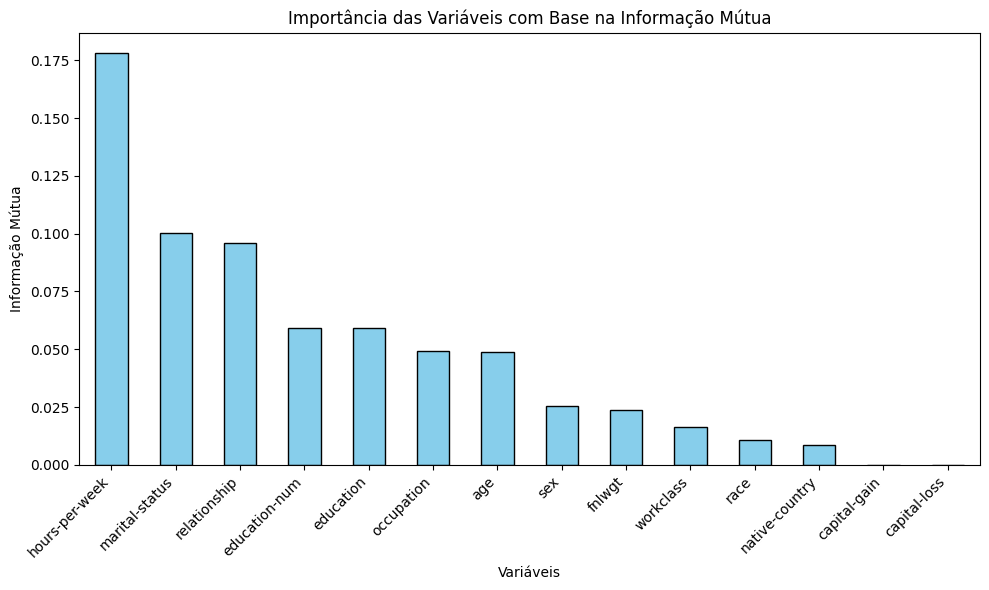

Top 7 variáveis mais importantes com base na Informação Mútua:
hours-per-week    0.177958
marital-status    0.100407
relationship      0.095896
education-num     0.059285
education         0.059084
occupation        0.049087
age               0.048738
dtype: float64

Nova tabela com as 7 variáveis mais importantes e a coluna alvo:
    hours-per-week  marital-status  relationship  education-num  education  \
0               40               0             1              9         11   
1               40               2             0              7          1   
2               40               2             5             13          9   
3               40               2             5             14         12   
4               35               4             3              9         11   
5               40               4             4              9         11   
6               40               0             4              9         11   
7               40               4         

In [ ]:

# Carregar o dataset
df = pd.read_csv('./colunas_limpas.csv')

# Definir a coluna alvo e as variáveis independentes
target_var = 'income'  # Coluna alvo
independent_vars = ["age", "workclass", "fnlwgt", "education", "education-num",
                    "marital-status", "occupation", "relationship", "race", "sex",
                    "capital-gain", "capital-loss", "hours-per-week", "native-country"]

# Selecionar as variáveis independentes (X) e a variável dependente (y)
X = df[independent_vars]
y = df[target_var]

# Codificar variáveis categóricas com LabelEncoder
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Salvar o encoder caso seja necessário reverter

# Calcular a Informação Mútua
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

# Plotar o histograma da Informação Mútua
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Importância das Variáveis com Base na Informação Mútua")
plt.xlabel("Variáveis")
plt.ylabel("Informação Mútua")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Exibir as 7 variáveis mais importantes
top_7_features = mi_series.head(7)
print("Top 7 variáveis mais importantes com base na Informação Mútua:")
print(top_7_features)

# Criar uma nova tabela com as 7 variáveis mais importantes + a coluna alvo
top_7_vars = top_7_features.index.tolist()  # Obter os nomes das 7 variáveis
new_df = df[top_7_vars + [target_var]]  # Criar nova tabela com essas variáveis e a coluna alvo

# Exibir as primeiras linhas da nova tabela
print("\nNova tabela com as 7 variáveis mais importantes e a coluna alvo:")
print(new_df.head(50))

# Salvar a nova tabela em um arquivo CSV
new_df.to_csv('top_7_features_table.csv', index=False)
print("Nova tabela salva como 'top_7_features_table.csv'")


# Estruturação da Rede Bayesiana







  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]


Melhor Estrutura Encontrada (Arestas - BIC Score):
[('hours-per-week', 'income'), ('marital-status', 'relationship'), ('marital-status', 'age'), ('relationship', 'occupation'), ('education', 'education-num'), ('occupation', 'education'), ('income', 'marital-status'), ('income', 'occupation'), ('income', 'education')]

Estrutura alternativa (Arestas - K2 Score):
[('hours-per-week', 'age'), ('hours-per-week', 'income'), ('hours-per-week', 'occupation'), ('hours-per-week', 'relationship'), ('hours-per-week', 'education-num'), ('hours-per-week', 'education'), ('marital-status', 'relationship'), ('marital-status', 'age'), ('marital-status', 'occupation'), ('marital-status', 'education-num'), ('marital-status', 'education'), ('relationship', 'age'), ('relationship', 'occupation'), ('relationship', 'education-num'), ('relationship', 'education'), ('education', 'age'), ('education', 'occupation'), ('education', 'education-num'), ('education-num', 'age'), ('education-num', 'occupation'), ('occ

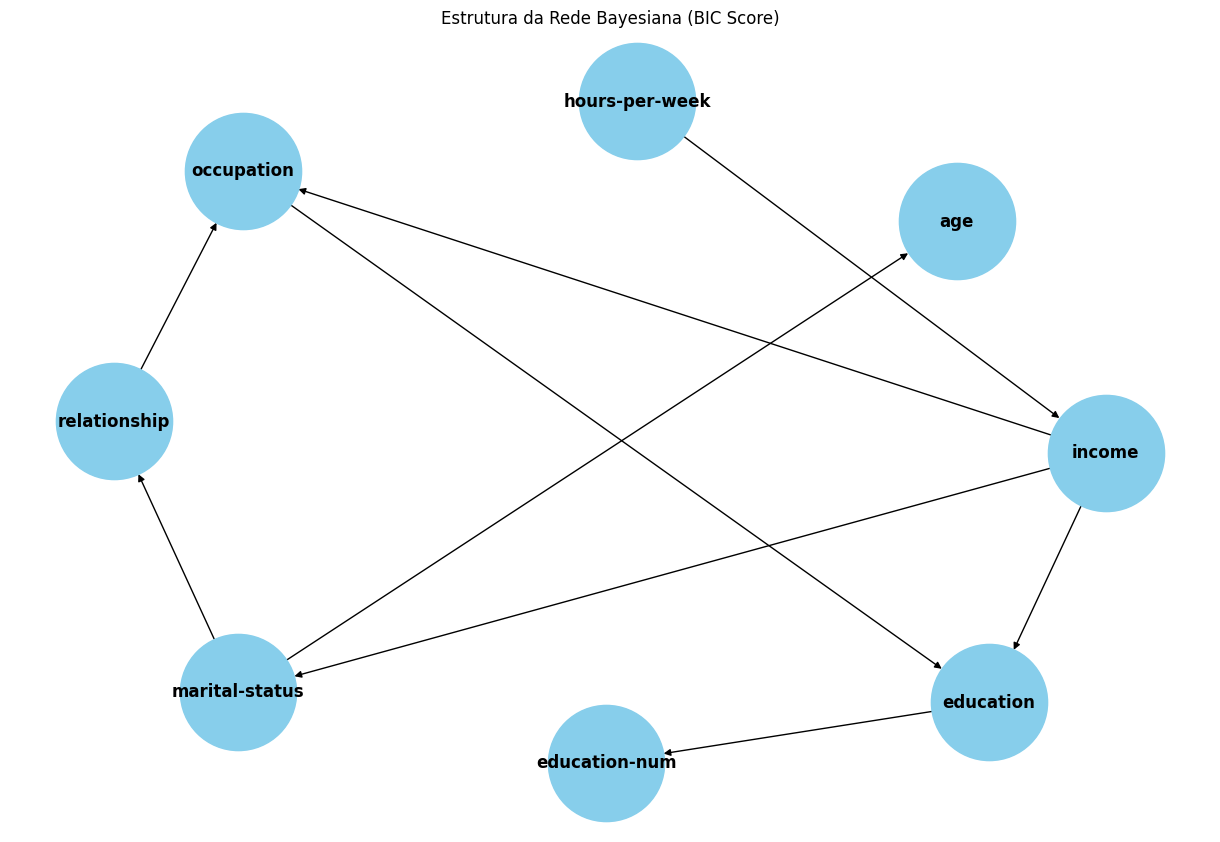

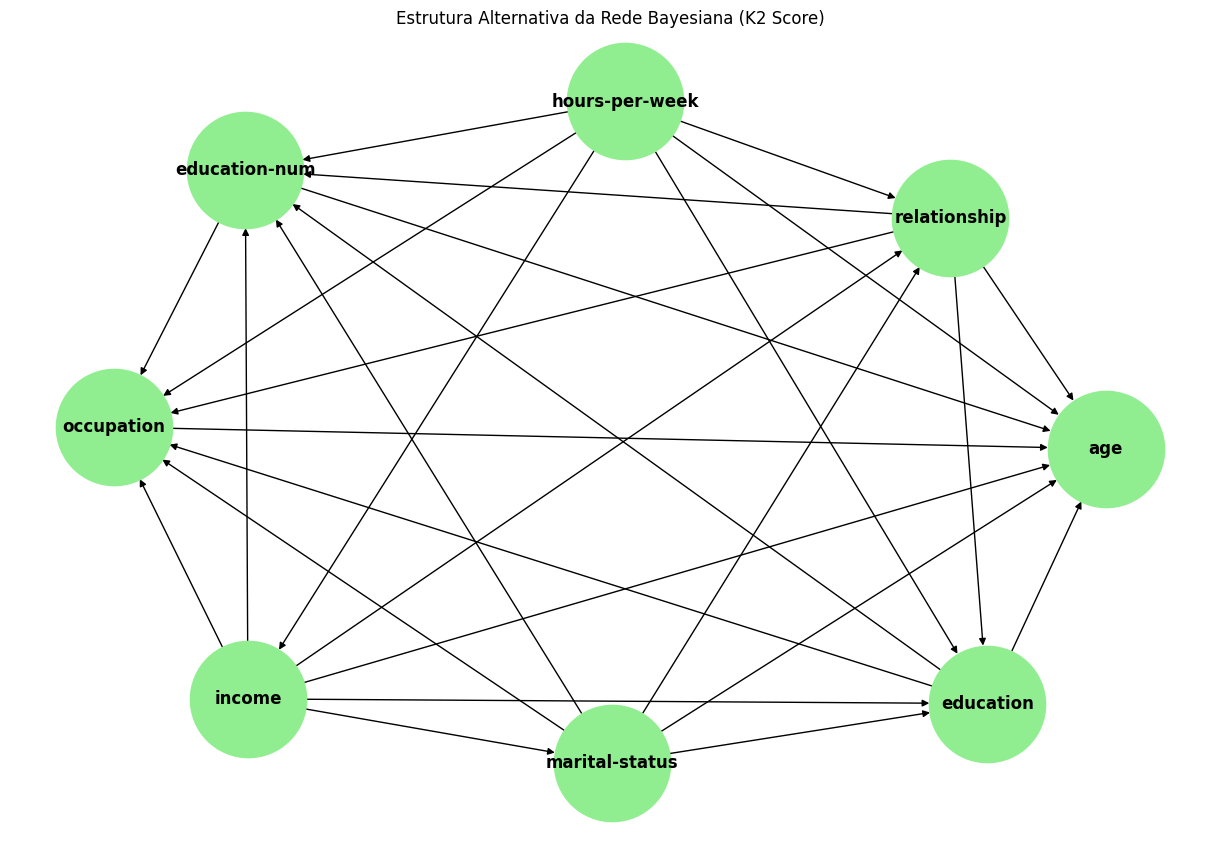

In [ ]:
# Carregar o arquivo CSV que contém as colunas mais importantes para análise
df = pd.read_csv('./top_7_features_table.csv')
df = df.sample(n=22405, random_state=42)  # Amostra aleatória de 25000 linhas para facilitar o processamento com duração de 15 minutos

# Passo 1: Descobrir a melhor estrutura da Rede Bayesiana usando Hill Climbing e BIC Score
# Criar o estimador para Hill Climbing
# Hill Climb Search é usado para encontrar a melhor estrutura da rede com base nos dados
est = HillClimbSearch(df)

# Usar o BIC Score para avaliar as estruturas e o K2 Score para comparação
# Estima a estrutura da rede com os métodos BIC e K2 para comparar os resultados
bic_model = est.estimate(scoring_method=BicScore(df))
k2_model = est.estimate(scoring_method=K2Score(df))

# Passo 2: Treinar a Rede Bayesiana com a melhor estrutura encontrada
# Criar a rede Bayesiana usando as arestas encontradas pelo modelo BIC
model = BayesianNetwork(bic_model.edges())
model.fit(df, estimator=MaximumLikelihoodEstimator)  # Treinar o modelo com o estimador de máxima verossimilhança

# Passo 3: Imprimir a estrutura da rede e as Tabelas de Probabilidade Condicional (CPDs)
# Exibir as arestas da melhor estrutura encontrada e as Tabelas de Probabilidade Condicional
print("\nMelhor Estrutura Encontrada (Arestas - BIC Score):")
print(bic_model.edges())

print("\nEstrutura alternativa (Arestas - K2 Score):")
print(k2_model.edges())

print("\nTabelas de Probabilidade Condicional (CPDs):")
for cpd in model.get_cpds():
    print(cpd)

# Passo 4: Desenhar o grafo da melhor estrutura usando BIC Score
plt.figure(figsize=(12, 8))
G = nx.DiGraph()
G.add_edges_from(bic_model.edges())
pos = nx.spring_layout(G, seed=42, k=4)  # Ajuste o valor de 'k' conforme necessário
nx.draw(G, pos, with_labels=True, node_size=7000, node_color="skyblue", font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Passo 5: Desenhar o grafo alternativo com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph()
G_k2.add_edges_from(k2_model.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42, k=4)  # Ajuste o valor de 'k' conforme necessário
nx.draw(G_k2, pos_k2, with_labels=True, node_size=7000, node_color="lightgreen", font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura Alternativa da Rede Bayesiana (K2 Score)")
plt.show()

# Treinamento e Ajuste de Hiperparâmetros






### Treinamento BIC

In [ ]:
# Carregar o dataset e reduzir o tamanho para facilitar o processamento
# Carrega o dataset filtrado e seleciona uma amostra de 15 registros com duraçao de 4, porque a maquina não suporta mais que isso
df = pd.read_csv('./top_7_features_table.csv')
df = df.sample(n=22000, random_state=42)

# Dividir os dados em conjuntos de treinamento e teste
# Divide o dataset em 70% para treinamento e 30% para teste
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Estruturação da Rede Bayesiana usando Hill Climb com BIC Score
# Utiliza Hill Climb Search para estimar a estrutura da rede com o BIC Score
hc = HillClimbSearch(train_data)
bic_model = hc.estimate(scoring_method=BicScore(train_data))



# Treinar a rede com a estrutura obtida pelo Hill Climb e BIC Score
# Define e treina um modelo Bayesiano com a estrutura do BIC Score usando estimativa de máxima verossimilhança
model_bic = BayesianNetwork(bic_model.edges())
model_bic.fit(train_data, estimator=MaximumLikelihoodEstimator)



# Exibir os nós presentes em cada modelo para verificar as variáveis incluídas
# Mostra as variáveis (nós) presentes em cada modelo
print("Nós no modelo Hill Climb (model_bic):", model_bic.nodes())

# Calcula o BIC Score para o modelo baseado em Hill Climb
bic_score_estimator = BicScore(train_data)
bic_score_value = bic_score_estimator.score(model_bic)
print("BIC Score para o modelo Hill Climb:", bic_score_value)


# Função auxiliar para mapear estados da evidência de acordo com o que o modelo aprendeu
# Define uma função para ajustar as evidências de acordo com os valores conhecidos pelo modelo
def map_evidence_values(model, evidence):
    mapped_evidence = {}
    for var, value in evidence.items():
        if var in model.nodes():
            state_names = model.get_cpds(var).state_names.get(var, [])
            # Verificar se o valor de evidência está na lista de estados aprendidos pelo modelo
            if value in state_names:
                mapped_evidence[var] = value
            else:
                print(f"Valor {value} não encontrado para a variável '{var}', removendo da evidência.")
    return mapped_evidence

# Evidências a serem usadas
# Define as evidências para inferência nos modelos
evidence_bic = {'relationship': 5, 'hours-per-week': 44}

# Ajustar as evidências para os estados aprendidos pelo modelo
# Ajusta as evidências de acordo com os valores conhecidos pelos modelos
mapped_evidence_bic = map_evidence_values(model_bic, evidence_bic)

# Inferência com o modelo Hill Climb
# Realiza a inferência no modelo Bayesiano treinado com o BIC Score
infer_bic = VariableElimination(model_bic)
query_result_bic = infer_bic.query(variables=['income'], evidence=mapped_evidence_bic)
print("\nResultado da inferência (modelo Hill Climb):")
print(query_result_bic)




  0%|          | 0/1000000 [00:00<?, ?it/s]

Nós no modelo Hill Climb (model_bic): ['marital-status', 'age', 'relationship', 'income', 'education-num', 'education', 'occupation', 'hours-per-week']
BIC Score para o modelo Hill Climb: -197217.47337484697

Resultado da inferência (modelo Hill Climb):
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.5986 |
+-----------+---------------+
| income(1) |        0.4014 |
+-----------+---------------+


### Treinamento BIC com Diferentes hiperparâmetros

In [ ]:
def run_inference_for_combinations(model, infer, relationship_values, hours_per_week_values):
    # Loop para percorrer os valores de relationship e hours-per-week
    for rel_value in relationship_values:
        for hours_value in hours_per_week_values:
            # Cria a evidência atual com os valores iterados
            evidence = {'relationship': rel_value, 'hours-per-week': hours_value}
            # Mapeia a evidência para os estados aprendidos pelo modelo
            mapped_evidence = map_evidence_values(model, evidence)

            if mapped_evidence:  # Verifica se a evidência foi mapeada corretamente
                query_result = infer.query(variables=['income'], evidence=mapped_evidence)
                print(f"Evidências: relationship={rel_value}, hours-per-week={hours_value}")
                print(query_result)
            else:
                print(f"Evidências inválidas: relationship={rel_value}, hours-per-week={hours_value}\n")


# Lista de valores para relationship e hours-per-week
relationship_values = [0, 1, 2, 3, 4, 5]
hours_per_week_values = [30, 35, 40, 44, 50, 60]

# Chama a função para executar a inferência para cada combinação
run_inference_for_combinations(model_bic, infer_bic, relationship_values, hours_per_week_values)


Evidências: relationship=0, hours-per-week=30
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.0000 |
+-----------+---------------+
| income(1) |        1.0000 |
+-----------+---------------+
Evidências: relationship=0, hours-per-week=35
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.8248 |
+-----------+---------------+
| income(1) |        0.1752 |
+-----------+---------------+
Evidências: relationship=0, hours-per-week=40
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.7416 |
+-----------+---------------+
| income(1) |        0.2584 |
+-----------+---------------+
Evidências: relationship=0, hours-per-week=44
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.5981 |
+-----------+---------------+
| income(1) |        0.4019 |
+-----

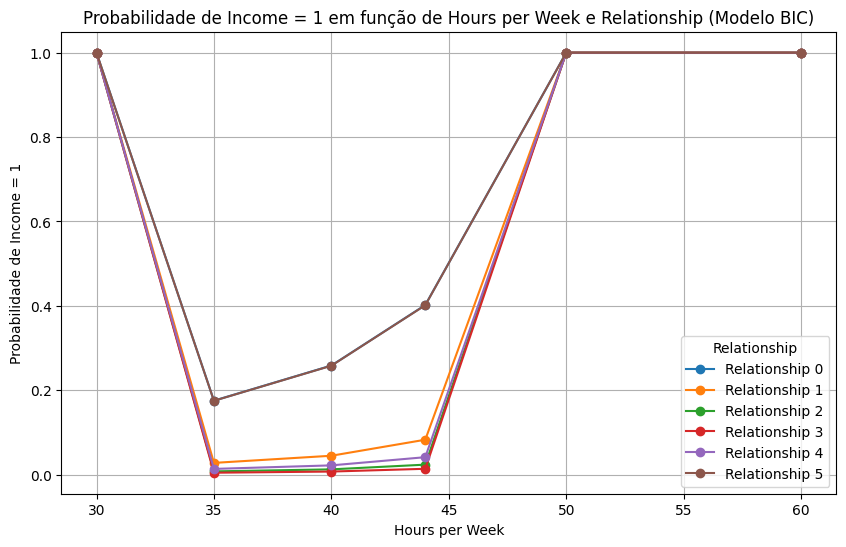

In [ ]:

# Função para executar a inferência e armazenar os resultados
def run_inference_for_combinations(model, infer, relationship_values, hours_per_week_values):
    # Lista para armazenar os resultados
    results = []

    # Loop para percorrer os valores de relationship e hours-per-week
    for rel_value in relationship_values:
        for hours_value in hours_per_week_values:
            # Cria a evidência atual com os valores iterados
            evidence = {'relationship': rel_value, 'hours-per-week': hours_value}
            # Mapeia a evidência para os estados aprendidos pelo modelo
            mapped_evidence = map_evidence_values(model, evidence)

            if mapped_evidence:  # Verifica se a evidência foi mapeada corretamente
                query_result = infer.query(variables=['income'], evidence=mapped_evidence)
                prob_income_1 = query_result.values[1]  # Probabilidade de "income = 1"
                # Armazena os resultados
                results.append({
                    'relationship': rel_value,
                    'hours-per-week': hours_value,
                    'prob_income_1': prob_income_1
                })
            else:
                print(f"Evidências inválidas: relationship={rel_value}, hours-per-week={hours_value}\n")

    # Converte os resultados em um DataFrame para facilitar a plotagem
    df_results = pd.DataFrame(results)
    return df_results

# Lista de valores para relationship e hours-per-week
relationship_values = [0, 1, 2, 3, 4, 5]
hours_per_week_values = [30, 35, 40, 44, 50, 60]

# Executa a inferência e armazena os resultados
df_results_bic = run_inference_for_combinations(model_bic, infer_bic, relationship_values, hours_per_week_values)

# Plotar os resultados
plt.figure(figsize=(10, 6))
for rel_value in relationship_values:
    subset = df_results_bic[df_results_bic['relationship'] == rel_value]
    plt.plot(subset['hours-per-week'], subset['prob_income_1'], marker='o', label=f'Relationship {rel_value}')

# Personalizar o gráfico
plt.title("Probabilidade de Income = 1 em função de Hours per Week e Relationship (Modelo BIC)")
plt.xlabel("Hours per Week")
plt.ylabel("Probabilidade de Income = 1")
plt.legend(title="Relationship")
plt.grid(True)
plt.show()


### Treinamento K2


In [ ]:


# Carregar o dataset e reduzir o tamanho para facilitar o processamento
df = pd.read_csv('./top_7_features_table.csv')
df = df.sample(n=22000, random_state=42)  # Reduzir a amostra para 3000 para otimizar

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Estruturação da Rede Bayesiana usando Hill Climb com K2 Score
hc = HillClimbSearch(train_data)
k2_model = hc.estimate(scoring_method=K2Score(train_data), max_indegree=2)  # Limita o número de pais para otimizar

# Treinar a rede com a estrutura obtida pelo Hill Climb e K2 Score
model_k2 = BayesianNetwork(k2_model.edges())
model_k2.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Exibir os nós presentes no modelo para verificar as variáveis incluídas
print("Nós no modelo Hill Climb (K2 Score):", model_k2.nodes())

# Função auxiliar para mapear estados da evidência de acordo com o que o modelo aprendeu
def map_evidence_values(model, evidence):
    mapped_evidence = {}
    for var, value in evidence.items():
        if var in model.nodes():
            state_names = model.get_cpds(var).state_names.get(var, [])
            if value in state_names:
                mapped_evidence[var] = value
    return mapped_evidence

# Evidências a serem usadas
evidence_k2 = {'relationship': 5, 'hours-per-week': 44}
mapped_evidence_k2 = map_evidence_values(model_k2, evidence_k2)

# Inferência com o modelo Hill Climb usando K2 Score
infer_k2 = VariableElimination(model_k2)
query_result_k2 = infer_k2.query(variables=['income'], evidence=mapped_evidence_k2)
print("\nResultado da inferência (modelo Hill Climb - K2 Score):")
print(query_result_k2)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Nós no modelo Hill Climb (K2 Score): ['hours-per-week', 'age', 'income', 'occupation', 'education-num', 'relationship', 'education', 'marital-status']

Resultado da inferência (modelo Hill Climb - K2 Score):
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.6567 |
+-----------+---------------+
| income(1) |        0.3433 |
+-----------+---------------+


### Treinamento K2 com Diferentes hiperparâmetros


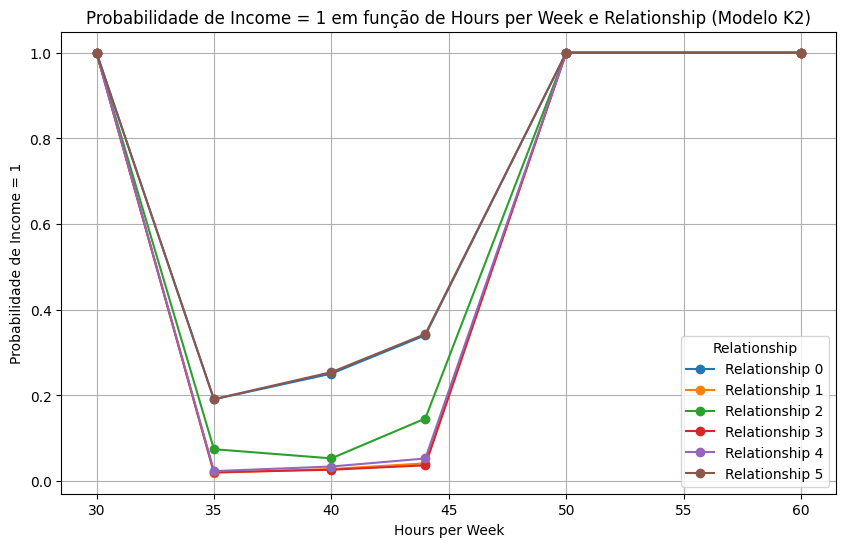

In [ ]:


# Função para executar a inferência e armazenar os resultados
def run_inference_for_combinations_k2(model, infer, relationship_values, hours_per_week_values):
    # Lista para armazenar os resultados
    results = []

    # Loop para percorrer os valores de relationship e hours-per-week
    for rel_value in relationship_values:
        for hours_value in hours_per_week_values:
            # Cria a evidência atual com os valores iterados
            evidence = {'relationship': rel_value, 'hours-per-week': hours_value}
            # Mapeia a evidência para os estados aprendidos pelo modelo
            mapped_evidence = map_evidence_values(model, evidence)

            if mapped_evidence:  # Verifica se a evidência foi mapeada corretamente
                query_result = infer.query(variables=['income'], evidence=mapped_evidence)
                prob_income_1 = query_result.values[1]  # Probabilidade de "income = 1"
                # Armazena os resultados
                results.append({
                    'relationship': rel_value,
                    'hours-per-week': hours_value,
                    'prob_income_1': prob_income_1
                })
            else:
                print(f"Evidências inválidas: relationship={rel_value}, hours-per-week={hours_value}\n")

    # Converte os resultados em um DataFrame para facilitar a plotagem
    df_results = pd.DataFrame(results)
    return df_results

# Lista de valores para relationship e hours-per-week
relationship_values = [0, 1, 2, 3, 4, 5]
hours_per_week_values = [30, 35, 40, 44, 50, 60]

# Executa a inferência e armazena os resultados
df_results = run_inference_for_combinations_k2(model_k2, infer_k2, relationship_values, hours_per_week_values)

# Plotar os resultados
plt.figure(figsize=(10, 6))
for rel_value in relationship_values:
    subset = df_results[df_results['relationship'] == rel_value]
    plt.plot(subset['hours-per-week'], subset['prob_income_1'], marker='o', label=f'Relationship {rel_value}')

# Personalizar o gráfico
plt.title("Probabilidade de Income = 1 em função de Hours per Week e Relationship (Modelo K2)")
plt.xlabel("Hours per Week")
plt.ylabel("Probabilidade de Income = 1")
plt.legend(title="Relationship")
plt.grid(True)
plt.show()


In [ ]:
def run_inference_for_combinations_k2(model, infer, relationship_values, hours_per_week_values):
    # Loop para percorrer os valores de relationship e hours-per-week
    for rel_value in relationship_values:
        for hours_value in hours_per_week_values:
            # Cria a evidência atual com os valores iterados
            evidence = {'relationship': rel_value, 'hours-per-week': hours_value}
            # Mapeia a evidência para os estados aprendidos pelo modelo
            mapped_evidence = map_evidence_values(model, evidence)

            if mapped_evidence:  # Verifica se a evidência foi mapeada corretamente
                query_result = infer.query(variables=['income'], evidence=mapped_evidence)
                print(f"Evidências: relationship={rel_value}, hours-per-week={hours_value}")
                print(query_result)
            else:
                print(f"Evidências inválidas: relationship={rel_value}, hours-per-week={hours_value}\n")

# Lista de valores para relationship e hours-per-week
relationship_values = [0, 1, 2, 3, 4, 5]
hours_per_week_values = [30, 35, 40, 44, 50, 60]

# Chama a função para executar a inferência para cada combinação no modelo K2
run_inference_for_combinations_k2(model_k2, infer_k2, relationship_values, hours_per_week_values)


Evidências: relationship=0, hours-per-week=30
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.0000 |
+-----------+---------------+
| income(1) |        1.0000 |
+-----------+---------------+
Evidências: relationship=0, hours-per-week=35
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.8091 |
+-----------+---------------+
| income(1) |        0.1909 |
+-----------+---------------+
Evidências: relationship=0, hours-per-week=40
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.7491 |
+-----------+---------------+
| income(1) |        0.2509 |
+-----------+---------------+
Evidências: relationship=0, hours-per-week=44
+-----------+---------------+
| income    |   phi(income) |
+===========+===============+
| income(0) |        0.6595 |
+-----------+---------------+
| income(1) |        0.3405 |
+-----

# Avaliação do Modelo

### Avaliação BIC

  0%|          | 0/1000000 [00:00<?, ?it/s]

Acurácia: 0.8988181818181818
Log-Loss (Entropia Cruzada): 0.2416377843060566
AUC: 0.9193282755130532


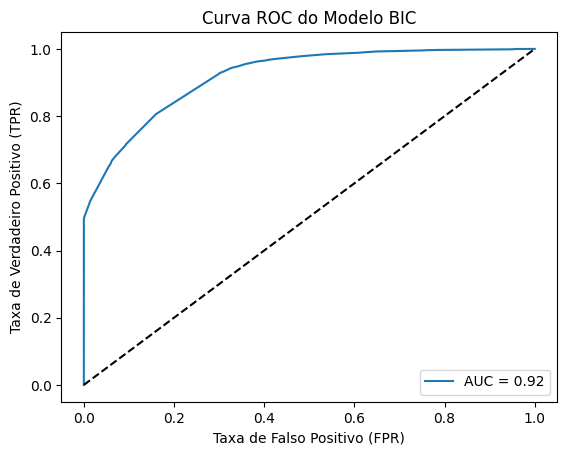

In [ ]:


# Exemplo de preparação do dataset
df = pd.read_csv('./top_7_features_table.csv')
df = df.sample(n=22000, random_state=42)

# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['income'])  # Ajuste 'income' para a coluna alvo
y = df['income']                 # Ajuste 'income' para a coluna alvo

# Estruturação da Rede Bayesiana
hc = HillClimbSearch(df)
model_structure = hc.estimate(scoring_method=BicScore(df))

# Treinar o modelo
model = BayesianNetwork(model_structure.edges())
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Inferência no modelo treinado
infer = VariableElimination(model)

# Avaliação do Modelo
y_true = []        # Valores reais
y_pred = []        # Valores preditos
y_pred_proba = []  # Probabilidades preditas para cálculo de AUC e Log-Loss

for _, row in df.iterrows():
    evidence = {col: row[col] for col in model.nodes() if col != 'income'}
    query_result = infer.query(variables=['income'], evidence=evidence)
    y_true.append(row['income'])
    y_pred.append(query_result.values.argmax())
    y_pred_proba.append(query_result.values[1])  # Probabilidade de 'income' ser 1

from sklearn.preprocessing import LabelEncoder

# Converter valores de y_true para binário (0 e 1) usando LabelEncoder
le = LabelEncoder()
y_true = le.fit_transform(y_true)  # Agora y_true terá valores binários (0 e 1)

# Avaliar o desempenho do modelo
print("Acurácia:", accuracy_score(y_true, y_pred))
print("Log-Loss (Entropia Cruzada):", log_loss(y_true, y_pred_proba))
print("AUC:", roc_auc_score(y_true, y_pred_proba))

# Exibir Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc_score(y_true, y_pred_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
plt.title("Curva ROC do Modelo BIC")
plt.legend(loc="lower right")
plt.show()



### Avaliação K2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Avaliação do modelo com K2 Score:
Acurácia: 0.8976363636363637
Log-Loss (Entropia Cruzada): 0.24103568951568732
AUC: 0.9199039178267286


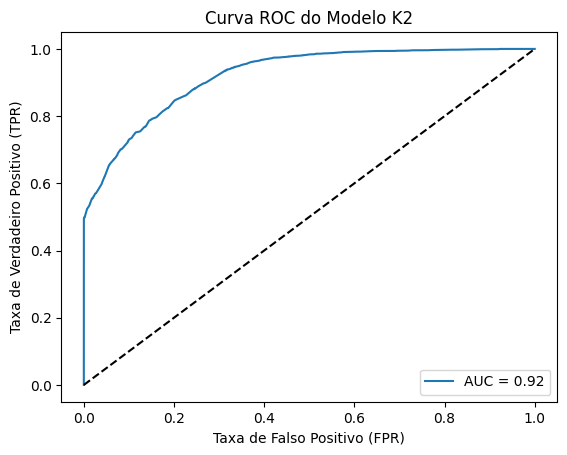

In [ ]:


# Carregar o dataset e selecionar uma amostra
df = pd.read_csv('./top_7_features_table.csv')
df = df.sample(n=22000, random_state=42)

# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['income'])
y = df['income']

# Estruturação da Rede Bayesiana usando Hill Climb com K2 Score
hc = HillClimbSearch(df)
k2_model_structure = hc.estimate(scoring_method=K2Score(df), max_indegree=2)

# Treinar o modelo K2
model_k2 = BayesianNetwork(k2_model_structure.edges())
model_k2.fit(df, estimator=MaximumLikelihoodEstimator)

# Função para realizar inferência e calcular métricas
def avaliar_modelo_k2(model, df, label_encoder):
    infer = VariableElimination(model)

    # Processar as inferências em lote
    y_true = label_encoder.transform(df['income'])  # Transforma y para binário (0 e 1)
    y_pred_proba = []
    y_pred = []

    for _, row in df.iterrows():
        evidence = {col: row[col] for col in model.nodes() if col != 'income'}
        query_result = infer.query(variables=['income'], evidence=evidence)

        # Adicionar probabilidades e predições
        y_pred_proba.append(query_result.values[1])  # Probabilidade de 'income' ser 1
        y_pred.append(query_result.values.argmax())  # Posição da classe predita (0 ou 1)

    # Avaliar o desempenho do modelo
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Log-Loss (Entropia Cruzada):", log_loss(y_true, y_pred_proba))
    auc_score = roc_auc_score(y_true, y_pred_proba)
    print("AUC:", auc_score)

    # Exibir Curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taxa de Falso Positivo (FPR)")
    plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
    plt.title("Curva ROC do Modelo K2")
    plt.legend(loc="lower right")
    plt.show()

# Codificar y_true para valores binários
le = LabelEncoder()
le.fit(y)

# Avaliação do modelo K2
print("Avaliação do modelo com K2 Score:")
avaliar_modelo_k2(model_k2, df, le)
